# SMS SPAM Detector

Collection of SMS messages tagged as spam or legitimate

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

https://www.kaggle.com/uciml/sms-spam-collection-dataset

### About This File

The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text. 

### Objective

The purpose of this project is to build a detection system to classify messages as spam or legitimate. For this, we will use a Natural Language Processing Neural Network based in Embedding and LSTM layers. Next, let's make a WordCloud to understand the more common expressions and words in messages classified as spam. 

The file RNN_NLP.py contains all classes and functions used in this work.

## 1. Data Pre-Processing 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# kaggle: https://www.kaggle.com/uciml/sms-spam-collection-dataset

data = pd.read_csv('spam.csv', encoding='ISO-8859-1')

data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

data.columns = ['labels', 'data']

data['labels'] = data['labels'].map({'ham': 0, 'spam': 1})

data.head()

,labels,data
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


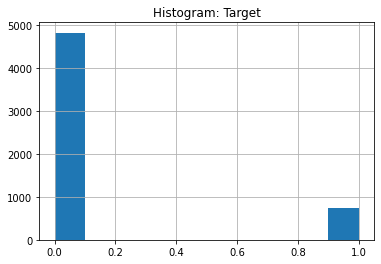

In [4]:
plt.hist(data['labels'])
plt.title('Histogram: Target')
plt.grid()
plt.show()


The classes are imbalanced.

In [5]:
Y = data['labels'].values

X_train, X_test, y_train, y_test = train_test_split(data['data'],Y, test_size=0.33, shuffle=True, stratify=Y)

Let's use the tokenization technique:

In [6]:
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size, lower=True)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)


In [7]:
train_lengths = [len(x) for x in sequences_train]
test_lengths = [len(x) for x in sequences_test]

In [8]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'There are {V} unique tokens.')

There are 7246 unique tokens.


Let's pad the messages to a commom size:

In [9]:
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 162)


In [10]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 162)


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
X_train_tensor = torch.from_numpy(data_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(data_test)
y_test_tensor = torch.from_numpy(y_test)

Let's create the dataloader to feed the neural network:

In [13]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=32, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=64, 
                                          shuffle=False)

In [14]:
for inputs, targets in train_loader:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shape:", targets.shape)
  break

inputs: tensor([[   0,    0,    0,  ..., 5705,  891,   25],
        [   0,    0,    0,  ...,   62,   47, 6285],
        [   0,    0,    0,  ...,   50,   43,  973],
        ...,
        [   0,    0,    0,  ...,  381, 3448, 3449],
        [   0,    0,    0,  ..., 1320,  196, 1449],
        [   0,    0,    0,  ...,   34, 2261,  124]], dtype=torch.int32) shape: torch.Size([32, 162])
targets: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0]) shape: torch.Size([32])


## 2. Natural Language Processing: 

The model and functions are in the file RNN_NLP.py. As the data is imbalanced, we will use weights to ensure equal importance for both classes in the training and testing weights optimization.

The model is made of:

- Embedding Layer
- Stacked-LSTM Layer
- FeedForward Layer

- Optimizer: Adam
- Loss Function: Binary Cross Entropy with Logits (prob<0.5 is negative)


If the test loss score increases for x consecutive times, the algorithm stops and returns the model from x iterations before.

- Weights Proportion: [0: (4825+747)/4825, 1: (4825+747)/747]

In [15]:
from RNN_NLP import NLP
from RNN_NLP import training_nn

model = NLP(V+1, 50, 16, 1, 1, device = device)

model.to(device)

criterion = nn.BCEWithLogitsLoss(reduce='none')

optimizer = torch.optim.Adam(model.parameters())

w = torch.tensor([(4825+747)/4825, (4825+747)/747])

C:\Users\Rafael Pavan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [16]:

train_losses, test_losses, model = training_nn(model, criterion, optimizer, train_loader, test_loader, epochs=30, early_stop = 1, device= device, weight = w )

Epoch 1/30, Train Loss: 0.8798,       Test Loss: 0.7208, Flag: 0
Epoch 2/30, Train Loss: 0.6518,       Test Loss: 0.5330, Flag: 0
Epoch 3/30, Train Loss: 0.4351,       Test Loss: 0.3343, Flag: 0
Epoch 4/30, Train Loss: 0.2717,       Test Loss: 0.2285, Flag: 0
Epoch 5/30, Train Loss: 0.1751,       Test Loss: 0.1800, Flag: 0
Epoch 6/30, Train Loss: 0.1239,       Test Loss: 0.1493, Flag: 0
Epoch 7/30, Train Loss: 0.0891,       Test Loss: 0.1326, Flag: 0
Epoch 8/30, Train Loss: 0.0661,       Test Loss: 0.1311, Flag: 0
Epoch 9/30, Train Loss: 0.0492,       Test Loss: 0.1259, Flag: 0
Epoch 10/30, Train Loss: 0.0405,       Test Loss: 0.1266, Flag: 1
Epoch 11/30, Train Loss: 0.0329,       Test Loss: 0.1251, Flag: 0
Epoch 12/30, Train Loss: 0.0260,       Test Loss: 0.1161, Flag: 0
Epoch 13/30, Train Loss: 0.0235,       Test Loss: 0.1178, Flag: 1
End of the Algorithm. The Neural Network didnt improve in the last 2 epochs


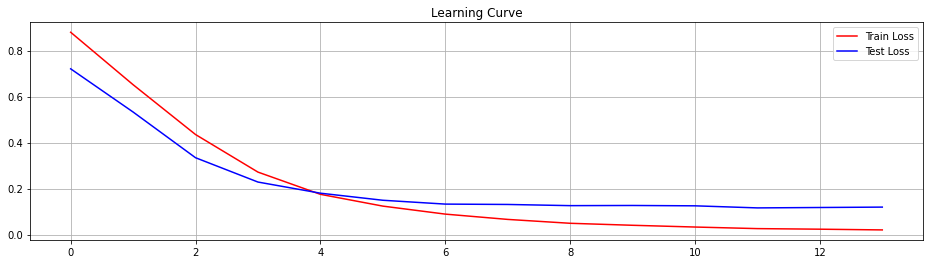

In [28]:
from RNN_NLP import plot_learning_curves

plt.figure(figsize=(16,4))
plot_learning_curves(train_losses, test_losses, title='Learning Curve')

In [18]:
from RNN_NLP import accuracy 
from RNN_NLP import plot_confusion_matrix_

model.load_state_dict(torch.load('NLP_RNN.pt'))

y_test, p_test = accuracy(model,train_loader,test_loader)

Train acc: 0.9989, Test acc: 0.9837


Confusion matrix
[[1584    8]
 [  22  225]]


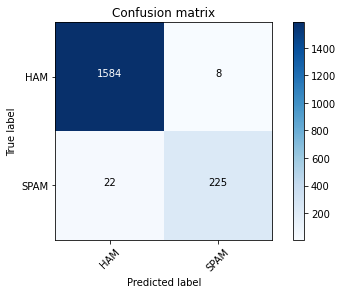

In [19]:
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix_(cm, ['HAM', 'SPAM'])


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test,p_test))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1592
         1.0       0.97      0.91      0.94       247

    accuracy                           0.98      1839
   macro avg       0.98      0.95      0.96      1839
weighted avg       0.98      0.98      0.98      1839



We can see by the table above the detection system performance. As the data is imbalanced, we must use the macro avg scores, that takes the average of precision, recall and f1-score of both classes.

## 3. WordCloud

Now, let's create a wordcloud to see common expressions and words from spam messages:

In [21]:
spam_data = data['data'][data['labels']==1]

spam_data = spam_data.str.lower()

spam_data.head()

2     free entry in 2 a wkly comp to win fa cup fina...
5     freemsg hey there darling it's been 3 week's n...
8     winner!! as a valued network customer you have...
9     had your mobile 11 months or more? u r entitle...
11    six chances to win cash! from 100 to 20,000 po...
Name: data, dtype: object

In [22]:
all_spam = spam_data.str.split(' ')

all_spam.head()

2     [free, entry, in, 2, a, wkly, comp, to, win, f...
5     [freemsg, hey, there, darling, it's, been, 3, ...
8     [winner!!, as, a, valued, network, customer, y...
9     [had, your, mobile, 11, months, or, more?, u, ...
11    [six, chances, to, win, cash!, from, 100, to, ...
Name: data, dtype: object

In [23]:
import string

spam_cleaned = []

for text in all_spam:

    text =  [x.strip(string.punctuation) for x in text]
    spam_cleaned.append(text)

text_spam = [" ".join(text) for text in spam_cleaned]

final_text_spam = " ".join(text_spam)


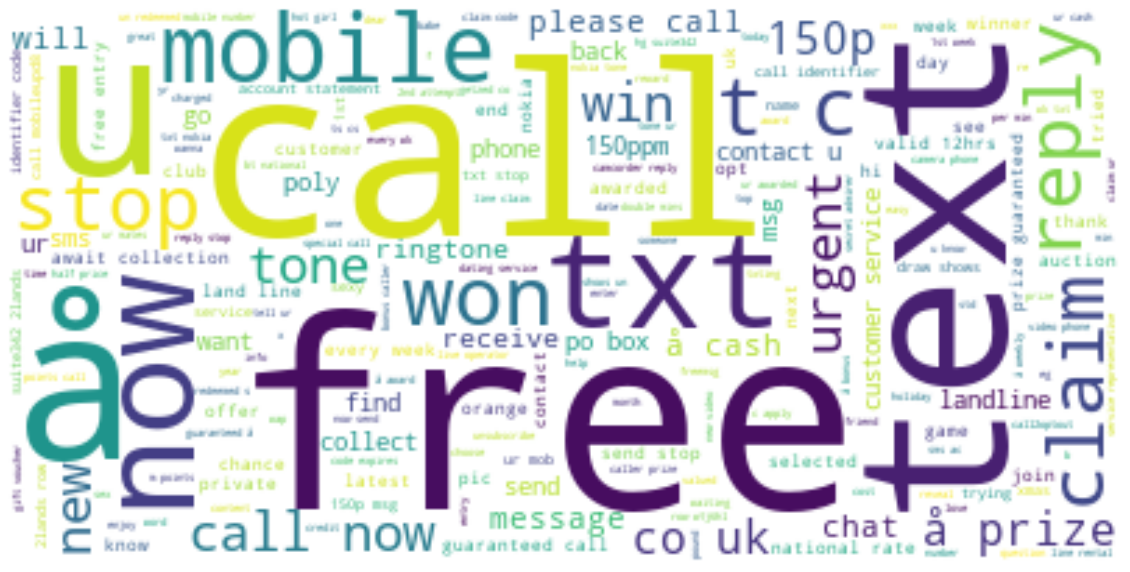

In [24]:
wordcloud_spam = WordCloud(background_color="white").generate(final_text_spam)

plt.figure(figsize = (20,20))

plt.imshow(wordcloud_spam, interpolation='bilinear')

plt.axis("off")

plt.show()

These words and expressions are common in spam messages:

    - Free
    - Mobile
    - Call
    - Urgent
    - Ringtone
    - Won
    - Prize
    - Please Call
    - ...


System Test:

In [25]:
test_sent = ['Hello Rafael, this is urgent! Call me now']


test_seq = tokenizer.texts_to_sequences(test_sent)

test_padded = pad_sequences(test_seq, maxlen=T)

if model(torch.from_numpy(test_padded).long().to(device)) > 0:
    print('detected: spam') 
else: print('detected: legitimate')

detected: spam


In [26]:
print(spam_data.iloc[12])

test_sent = [spam_data.iloc[12]]

test_seq = tokenizer.texts_to_sequences(test_sent)

test_padded = pad_sequences(test_seq, maxlen=T)

if model(torch.from_numpy(test_padded).long().to(device)) > 0:
    print('detected: spam') 
else: print('detected: legitimate')

as a valued customer, i am pleased to advise you that following recent review of your mob no. you are awarded with a å£1500 bonus prize, call 09066364589
detected: spam


The developed system succeeded in detecting a great number of spam messages, with a good precision and recall. 